# Exploratory experients

The purpose of this notebook is to perform some initial and preliminary analysis to the DER implementation with SplitCIFAR100.

Tests are performed on the validation set (10% of training set) and with 10 experiences (10 classes each).

## Imports

In [1]:
from avalanche.benchmarks.classic import SplitCIFAR10
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch

from torchvision.transforms import Compose, Normalize, ToTensor

/home/giacomo/mambaforge/envs/continual/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

Following the DER paper, 5 experiences  were used, each with 2 new classes.

We are in a Class-Incremental setting, without task labels.

In [2]:
num_experiences = 5

In [3]:
# Default Avalanche transformations are the same used in the DER paper
split_cifar10 = SplitCIFAR10(n_experiences=num_experiences, seed=42, train_transform=Compose([ToTensor(), Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))]))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(len(split_cifar10.train_stream[0].dataset))
print(len(split_cifar10.test_stream[0].dataset))

10000
2000


### Show some samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


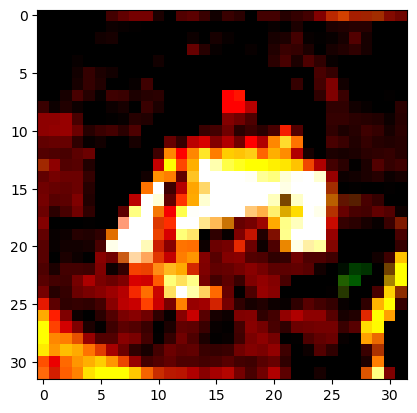

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


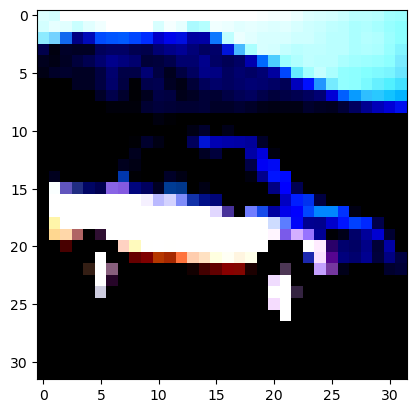

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


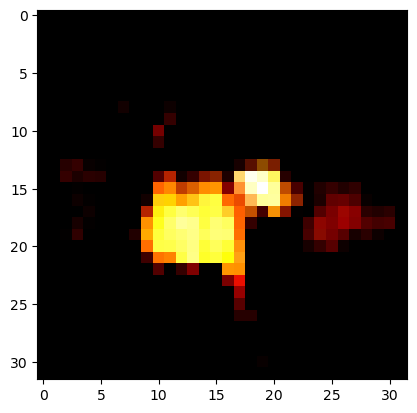

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


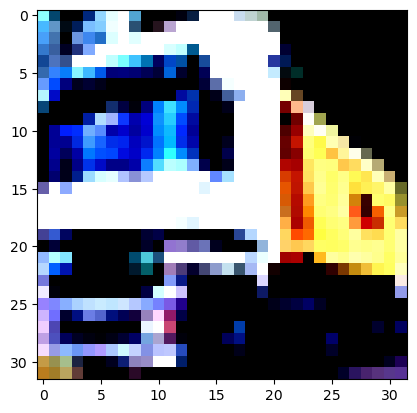

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


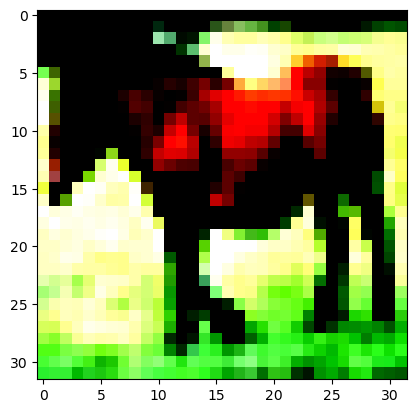

In [5]:
for experience in split_cifar10.train_stream:
    # Show the first 4 images in the experience
    for sample in experience.dataset:
        plt.imshow(sample[0].permute(1, 2, 0))
        plt.show()
        break

## Train

In [6]:
from torchvision.models import resnet18
from torch.nn import CrossEntropyLoss
from avalanche.training import Naive

In [7]:
if torch.cuda.is_available():       
        device = torch.device("cuda")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [8]:
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger

## DER++

In [9]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(trained_experience=True, stream=True, epoch_running=True),
    loss_metrics(stream=True, epoch_running=True, epoch=True),
    #forgetting_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger(), TextLogger(open('exploratory_SCIFAR10.txt', 'a'))],
    strict_checks=False
)

In [10]:
from der import DerPlugin

Choose best hyperparams from DER paper.

In [3]:
lr = 0.03
buffer_size = 500
alpha = 0.2
beta = 0.5
epochs = 50

In [12]:
model = resnet18(weights=None, num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()

der_plugin = DerPlugin(mem_size=buffer_size, alpha=alpha, beta=beta)

cl_strategy = Naive(model, optimizer, criterion, train_mb_size=64, train_epochs=epochs, eval_mb_size=64,
                    eval_every=-1, device=device, evaluator=eval_plugin, plugins=[der_plugin])

Training loop

In [13]:
exp_results = []

In [14]:
# TRAINING LOOP WITH EVALUATION AT EACH EPOCH

print('Starting experiment...')
results = []
for experience in split_cifar10.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    cl_strategy.train(experience)
    print('Training completed')

    exp_results.append(cl_strategy.eval(split_cifar10.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [2, 6]


-- >> Start of training phase << --
100%|██████████| 157/157 [00:09<00:00, 16.44it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.5051
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 1.5051
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.7156
100%|██████████| 157/157 [00:06<00:00, 23.95it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.7433
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.7433
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.7992
100%|██████████| 157/157 [00:06<00:00, 22.58it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6254
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.6254
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.8336
100%|██████████| 157/157 [00:06<00:00, 23.07it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5658
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.5658
	Top1_RunningAcc_Epoch/train_phase/train_stream/T

### Get the accuracy on current and previous experiences

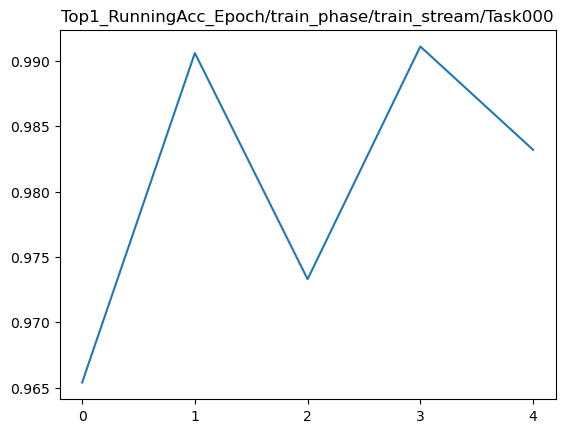

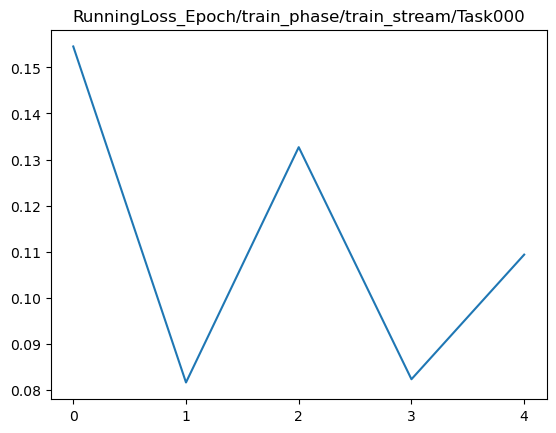

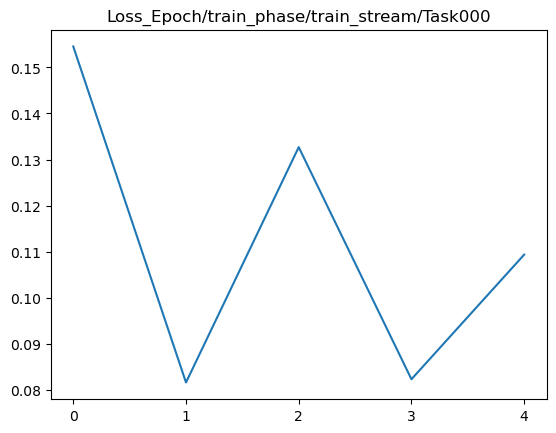

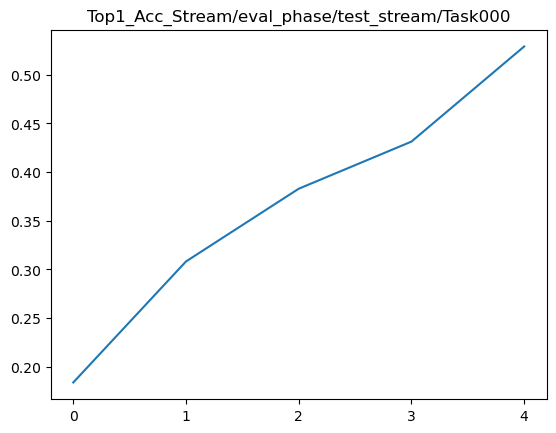

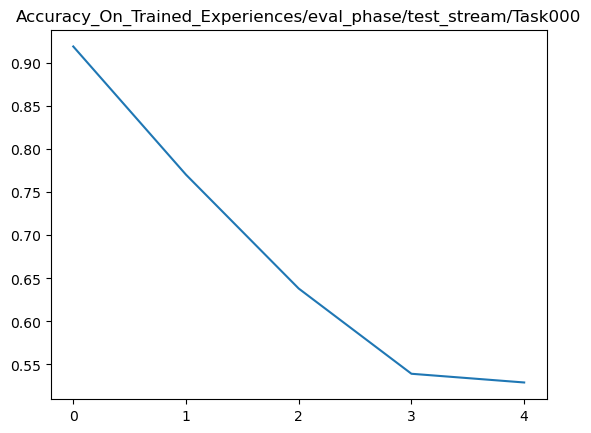

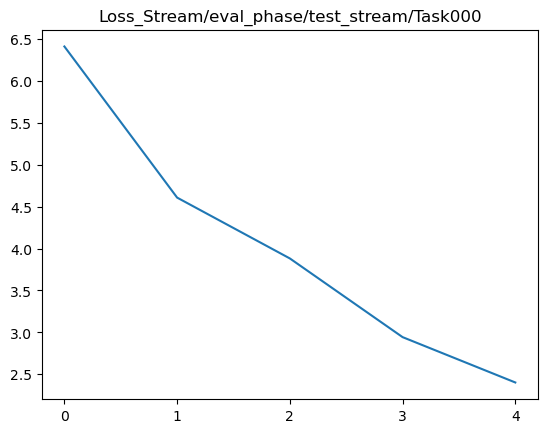

In [15]:
aggregated_results = {}

for i, exp_dict in enumerate(exp_results):
   for metric_name, metric_value in exp_dict.items():
        if metric_name not in aggregated_results:
            aggregated_results[metric_name] = []
            aggregated_results[metric_name].append(metric_value)
        else:
            aggregated_results[metric_name].append(metric_value)

for metric_name, metric_values in aggregated_results.items():
    plt.plot(metric_values, label=metric_name)
    plt.title(metric_name)
    plt.xticks(range(len(metric_values)))
    plt.show()

acc_stream_der = aggregated_results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
acc_trained_exps_der = aggregated_results['Accuracy_On_Trained_Experiences/eval_phase/test_stream/Task000']
loss_stream_der = aggregated_results['Loss_Stream/eval_phase/test_stream/Task000']

### Plot the loss curve for each experience

In [4]:
with open('exploratory_SCIFAR10.txt', 'r') as f:
# In the log file find all the lines starting with "Loss_Epoch"
    lines = [line for line in f.readlines() if line.startswith('\tLoss_Epoch')]
    # Get the final loss at each line after the = sign
    epoch_losses_list = [float(line.split('=')[1]) for line in lines]
    
# Divide by experiences
exp_epoch_losses = [epoch_losses_list[i:i+epochs] for i in range(0, len(epoch_losses_list), epochs)]


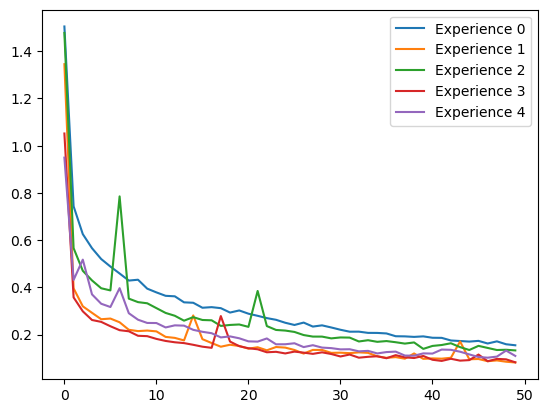

In [7]:
# Plot the loss for each experience
for i, exp_epoch_loss in enumerate(exp_epoch_losses):
    plt.plot(exp_epoch_loss, label=f'Experience {i}')
plt.xticks(range(0, epochs+1, 10))
plt.legend()
plt.show()

Plot the full loss curve across the experiences

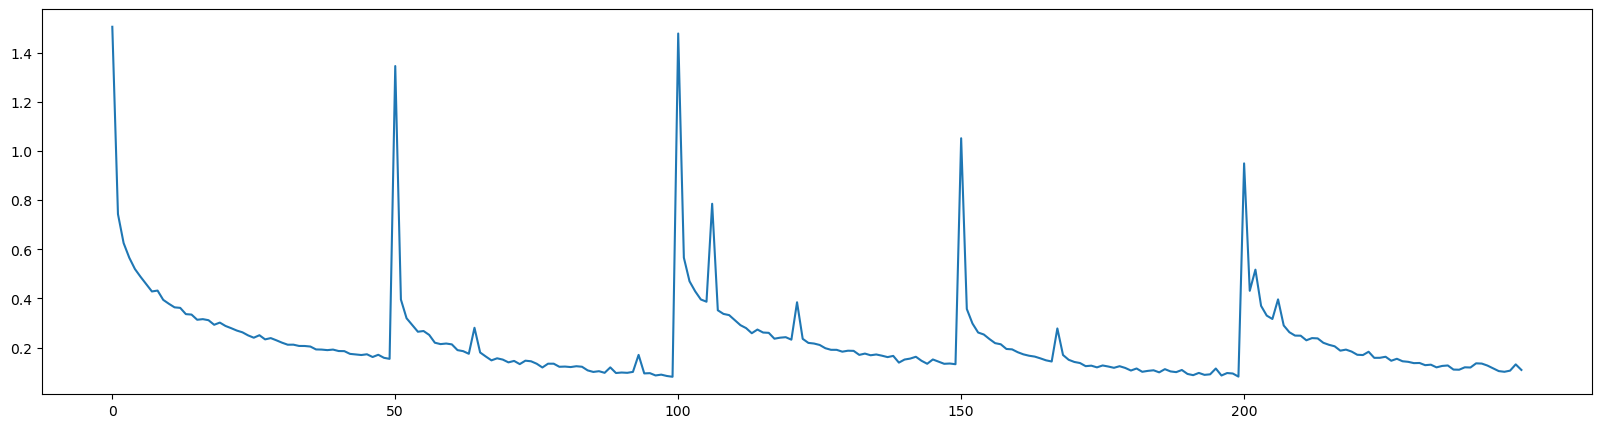

In [18]:
full_loss_stream = []
for i, exp_epoch_loss in enumerate(exp_epoch_losses):
    full_loss_stream += exp_epoch_loss

plt.plot(full_loss_stream)
plt.xticks(range(0, len(full_loss_stream), epochs))
plt.gcf().set_size_inches(20, 5)
plt.show()

### Check labels occurrences in the buffer are balanced

In [19]:
labels, occurrences = der_plugin.get_buffer_labels()
for label, occ in zip(labels, occurrences):
    print(f'Label: {label} - Occurrences: {occ}')

Label: 0 - Occurrences: 55
Label: 1 - Occurrences: 46
Label: 2 - Occurrences: 43
Label: 3 - Occurrences: 52
Label: 4 - Occurrences: 38
Label: 5 - Occurrences: 47
Label: 6 - Occurrences: 64
Label: 7 - Occurrences: 52
Label: 8 - Occurrences: 51
Label: 9 - Occurrences: 52


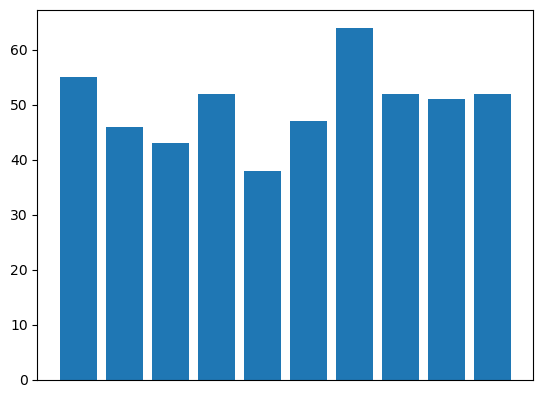

In [20]:
# make bar plot of the occurrences, with no xaxis label
plt.bar(labels, occurrences)
plt.xticks([])
plt.show()


# Experience Replay

In [21]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(trained_experience=True, stream=True, epoch_running=True),
    loss_metrics(stream=True, epoch_running=True, epoch=True),
    #forgetting_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger(), TextLogger(open('exploratory_SCIFAR10_replay.txt', 'a'))],
    strict_checks=False
)

In [22]:
from avalanche.training import Replay

In [23]:
lr = 0.1
buffer_size = 500
epochs = 50

In [24]:
model = resnet18(weights=None, num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()

cl_strategy = Replay(model, optimizer, criterion, mem_size=buffer_size, train_mb_size=64, train_epochs=epochs, eval_mb_size=64,
                    eval_every=-1, device=device, evaluator=eval_plugin)

In [25]:
exp_results = []

In [26]:
# TRAINING LOOP WITH EVALUATION AT EACH EPOCH

print('Starting experiment...')
results = []
for experience in split_cifar10.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    cl_strategy.train(experience)
    print('Training completed')

    exp_results.append(cl_strategy.eval(split_cifar10.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [2, 6]
-- >> Start of training phase << --
  1%|          | 1/157 [00:00<00:05, 31.17it/s]

100%|██████████| 157/157 [00:03<00:00, 42.44it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8282
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.8282
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.7397
100%|██████████| 157/157 [00:03<00:00, 44.95it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4030
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.4030
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.8245
100%|██████████| 157/157 [00:03<00:00, 45.05it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3580
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.3580
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.8500
100%|██████████| 157/157 [00:03<00:00, 46.68it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2922
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.2922
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.8801
100%|██████████| 157

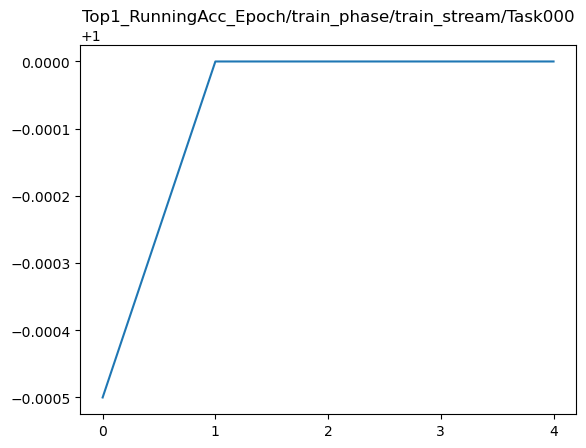

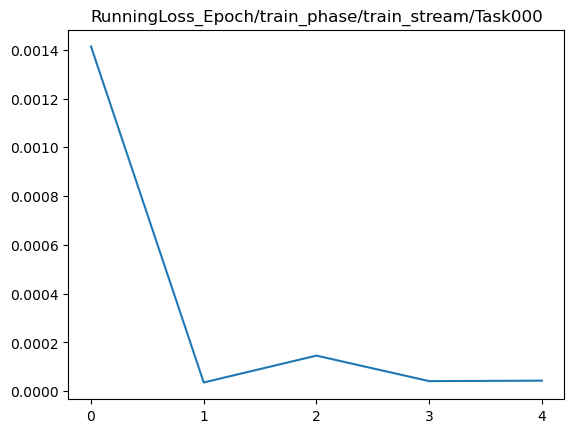

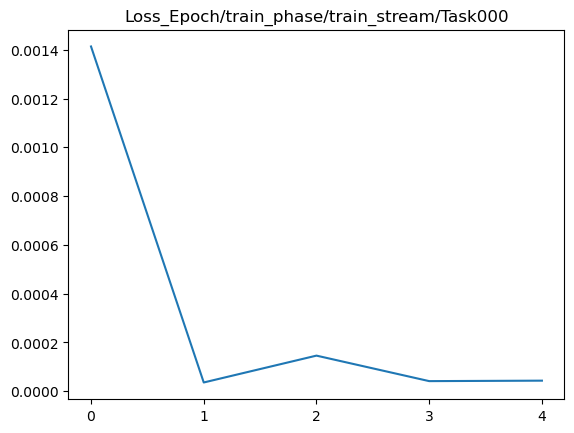

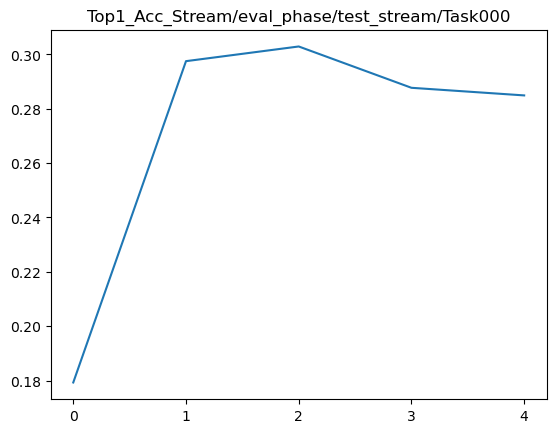

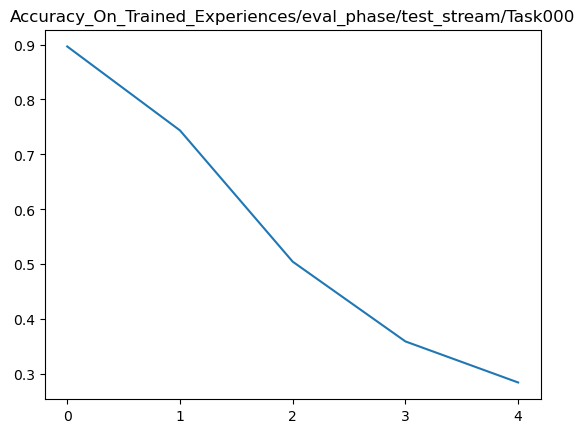

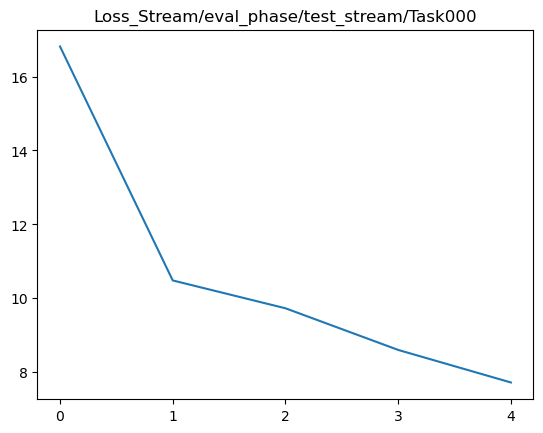

In [27]:
aggregated_results = {}

for i, exp_dict in enumerate(exp_results):
   for metric_name, metric_value in exp_dict.items():
        if metric_name not in aggregated_results:
            aggregated_results[metric_name] = []
            aggregated_results[metric_name].append(metric_value)
        else:
            aggregated_results[metric_name].append(metric_value)

for metric_name, metric_values in aggregated_results.items():
    plt.plot(metric_values, label=metric_name)
    plt.title(metric_name)
    plt.xticks(range(len(metric_values)))
    plt.show()

acc_stream_er = aggregated_results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
acc_trained_exps_er = aggregated_results['Accuracy_On_Trained_Experiences/eval_phase/test_stream/Task000']
loss_stream_er = aggregated_results['Loss_Stream/eval_phase/test_stream/Task000']

# Naive

In [28]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(trained_experience=True, stream=True, epoch_running=True),
    loss_metrics(stream=True, epoch_running=True, epoch=True),
    #forgetting_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger(), TextLogger(open('exploratory_SCIFAR10_naive.txt', 'a'))],
    strict_checks=False
)

In [29]:
from avalanche.training import Replay

In [30]:
lr = 0.1
epochs = 50

In [31]:
model = resnet18(weights=None, num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()

cl_strategy = Naive(model, optimizer, criterion, train_mb_size=64, train_epochs=epochs, eval_mb_size=64,
                    eval_every=-1, device=device, evaluator=eval_plugin)

In [32]:
exp_results = []

In [33]:
# TRAINING LOOP WITH EVALUATION AT EACH EPOCH

print('Starting experiment...')
results = []
for experience in split_cifar10.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    cl_strategy.train(experience)
    print('Training completed')

    exp_results.append(cl_strategy.eval(split_cifar10.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [2, 6]
-- >> Start of training phase << --
0it [00:00, ?it/s]

100%|██████████| 157/157 [00:05<00:00, 26.47it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8698
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.8698
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.7228
100%|██████████| 157/157 [00:05<00:00, 27.23it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4421
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.4421
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.8144
100%|██████████| 157/157 [00:04<00:00, 34.00it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3660
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.3660
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.8533
100%|██████████| 157/157 [00:04<00:00, 34.44it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3115
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.3115
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.8674
100%|██████████| 157

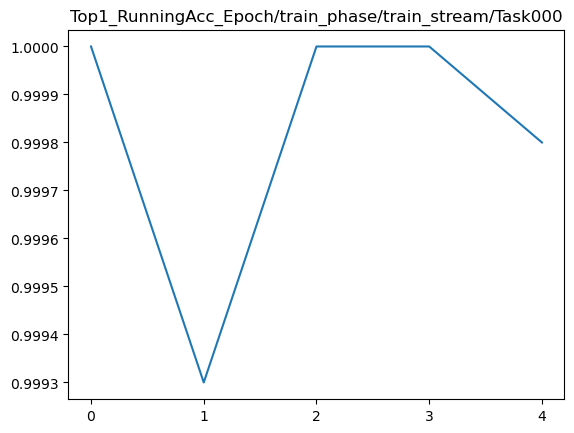

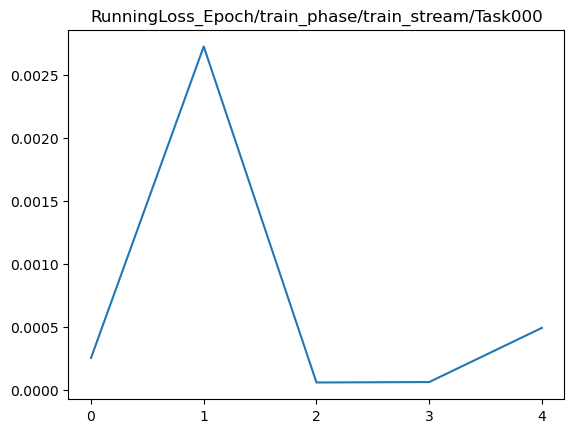

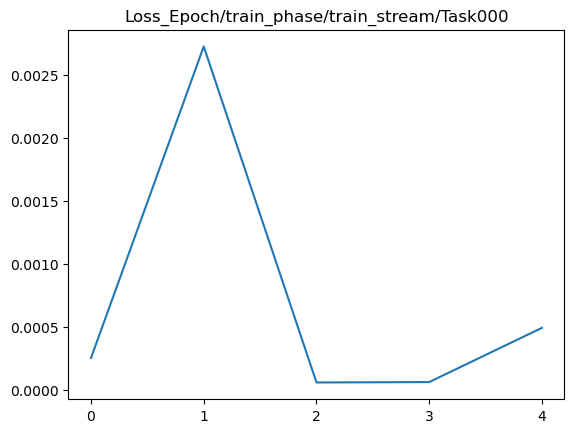

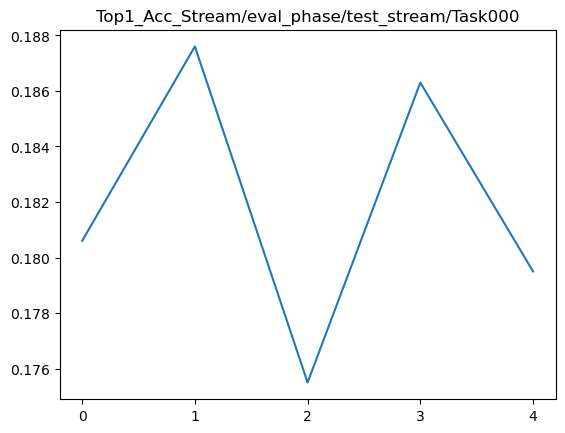

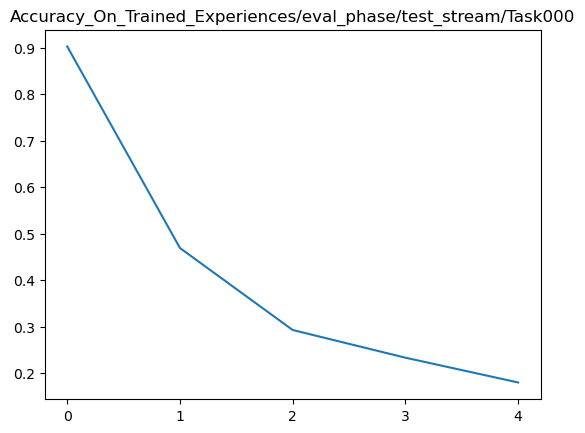

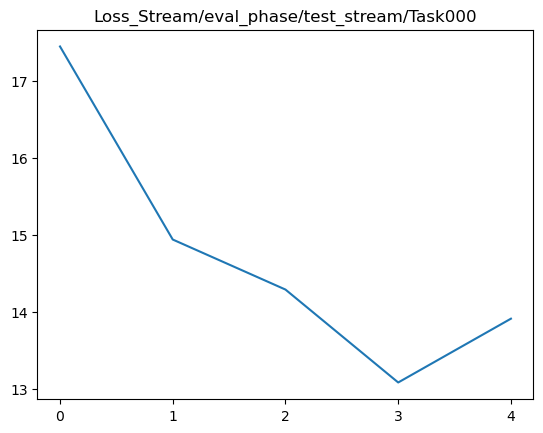

In [34]:
aggregated_results = {}

for i, exp_dict in enumerate(exp_results):
   for metric_name, metric_value in exp_dict.items():
        if metric_name not in aggregated_results:
            aggregated_results[metric_name] = []
            aggregated_results[metric_name].append(metric_value)
        else:
            aggregated_results[metric_name].append(metric_value)

for metric_name, metric_values in aggregated_results.items():
    plt.plot(metric_values, label=metric_name)
    plt.title(metric_name)
    plt.xticks(range(len(metric_values)))
    plt.show()

acc_stream_naive = aggregated_results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
acc_trained_exps_naive = aggregated_results['Accuracy_On_Trained_Experiences/eval_phase/test_stream/Task000']
loss_stream_naive = aggregated_results['Loss_Stream/eval_phase/test_stream/Task000']

# Compare DER, ER and Naive on test stream

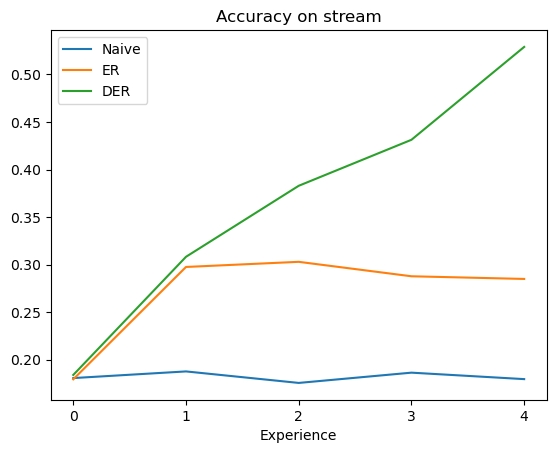

In [35]:
plt.plot(acc_stream_naive, label='Naive')
plt.plot(acc_stream_er, label='ER')
plt.plot(acc_stream_der, label='DER')
plt.xticks(range(len(acc_stream_naive)))
plt.xlabel('Experience')
plt.title('Accuracy on stream')
plt.legend()
plt.show()

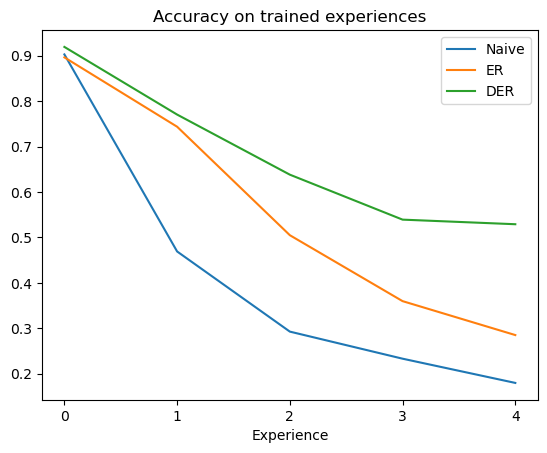

In [36]:
plt.plot(acc_trained_exps_naive, label='Naive')
plt.plot(acc_trained_exps_er, label='ER')
plt.plot(acc_trained_exps_der, label='DER')
plt.xticks(range(len(acc_stream_naive)))
plt.xlabel('Experience')
plt.title('Accuracy on trained experiences')
plt.legend()
plt.show()

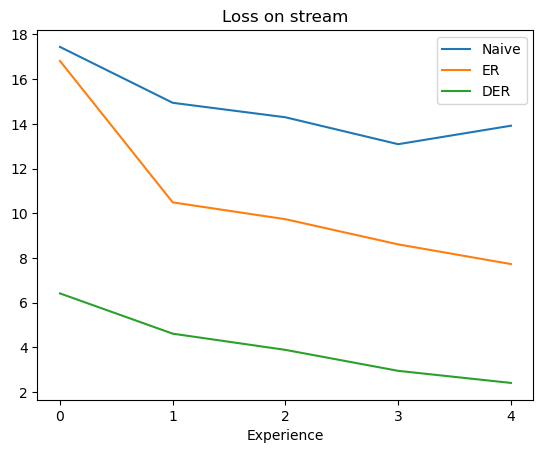

In [37]:
plt.plot(loss_stream_naive, label='Naive')  
plt.plot(loss_stream_er, label='ER')
plt.plot(loss_stream_der, label='DER')
plt.xticks(range(len(acc_stream_naive)))
plt.xlabel('Experience')
plt.title('Loss on stream')
plt.legend()
plt.show()